In [ ]:
import os
import cv2
import glob
import joblib
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from skimage.feature import hog

# -----------------------
# Reproducibility
# -----------------------
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# -----------------------
# Paths
# -----------------------
DATA_DIR = "data"
TEST_DIR = "test_data"
OUT_FIG = "outputs/fig"
OUT_MODEL = "outputs/model"

os.makedirs(OUT_FIG, exist_ok=True)
os.makedirs(OUT_MODEL, exist_ok=True)

# -----------------------
# Parameters
# -----------------------
NUM_CLUSTERS = 300
HOG_PARAMS = dict(
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm="L2-Hys",
    visualize=True
)


### Dataset Overview

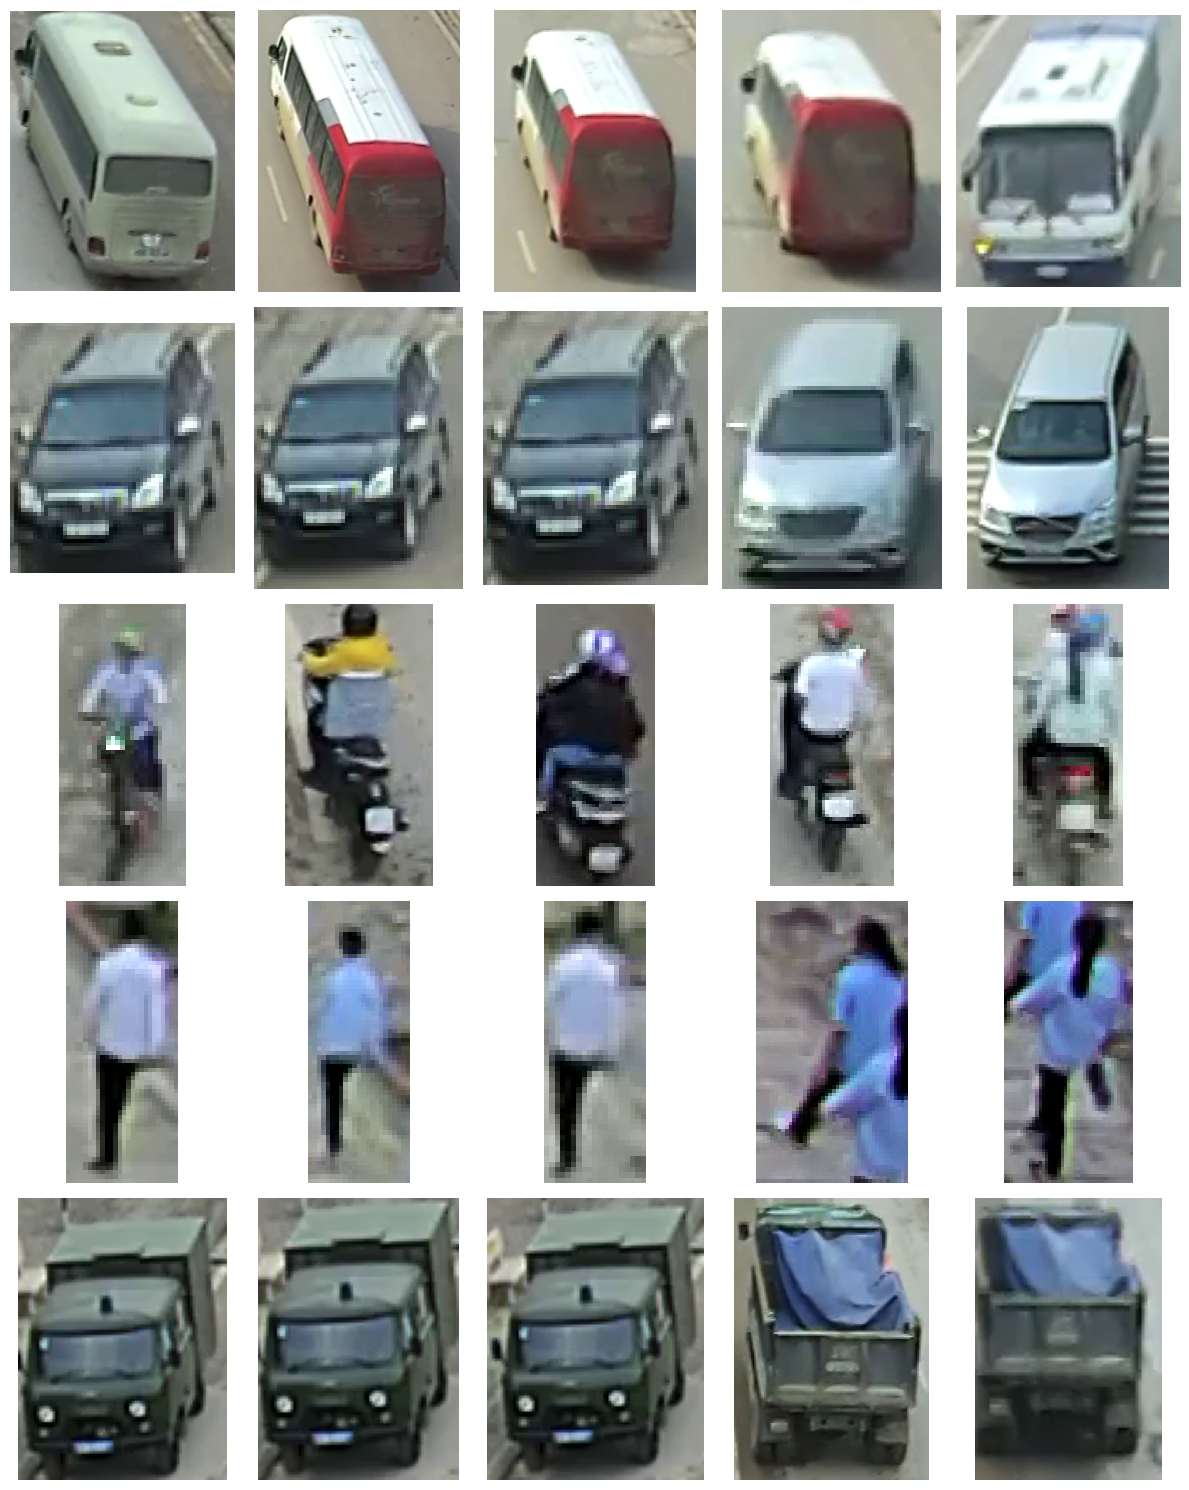

In [ ]:
def load_dataset(root):
    images, labels = [], []
    label2id = {}
    for idx, cls in enumerate(sorted(os.listdir(root))):
        cls_path = os.path.join(root, cls)
        if not os.path.isdir(cls_path):
            continue
        label2id[cls] = idx
        for img_path in glob.glob(f"{cls_path}/*"):
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(idx)
    return images, np.array(labels), label2id

images, labels, label2id = load_dataset(DATA_DIR)
id2label = {v: k for k, v in label2id.items()}

# Visualize samples
samples_per_class = 5
plt.figure(figsize=(12, 3 * len(label2id)))
idx = 1
for label in sorted(label2id.values()):
    class_imgs = [img for img, y in zip(images, labels) if y == label]
    for i in range(samples_per_class):
        plt.subplot(len(label2id), samples_per_class, idx)
        plt.imshow(cv2.cvtColor(class_imgs[i], cv2.COLOR_BGR2RGB))
        plt.axis("off")
        if i == 0:
            plt.ylabel(id2label[label], fontsize=12)
        idx += 1

plt.tight_layout()
plt.savefig(f"{OUT_FIG}/dataset_samples.png", dpi=300)
plt.show()


### Prepocessing

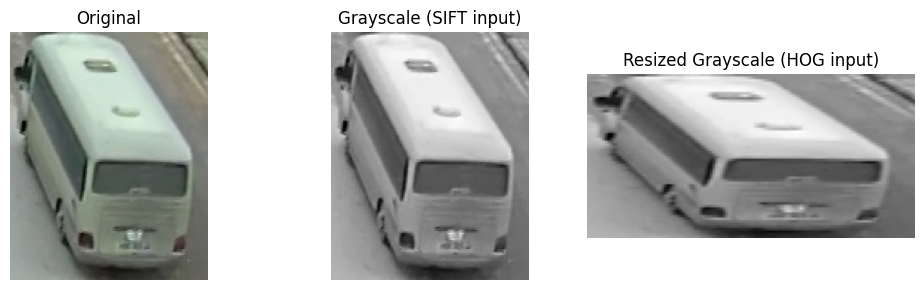

In [ ]:
def preprocess_for_features(img, hog_size=(128, 64)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_in = cv2.resize(gray, hog_size)
    return gray, hog_in

sample = images[0]
gray, hog_in = preprocess_for_features(sample)

plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(gray, cmap="gray")
plt.title("Grayscale (SIFT input)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(hog_in, cmap="gray")
plt.title("Resized Grayscale (HOG input)")
plt.axis("off")

plt.tight_layout()
plt.savefig(f"{OUT_FIG}/preprocessing_used.png", dpi=300)
plt.show()


### Sift Keypoint Feature Detection

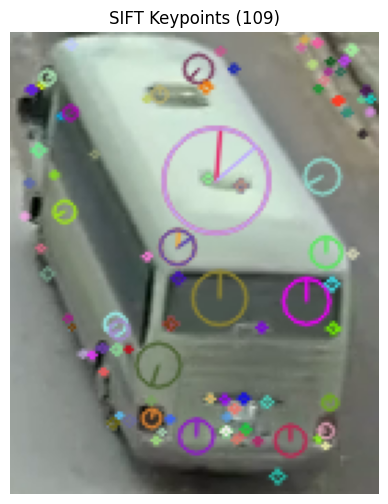

In [ ]:
sift = cv2.SIFT_create()

gray = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
kp, desc = sift.detectAndCompute(gray, None)
kp_img = cv2.drawKeypoints(sample, kp, None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(kp_img, cv2.COLOR_BGR2RGB))
plt.title(f"SIFT Keypoints ({len(kp)})")
plt.axis("off")
plt.savefig(f"{OUT_FIG}/sift_keypoints.png", dpi=300)
plt.show()


### SIFT DECSRIPTOR

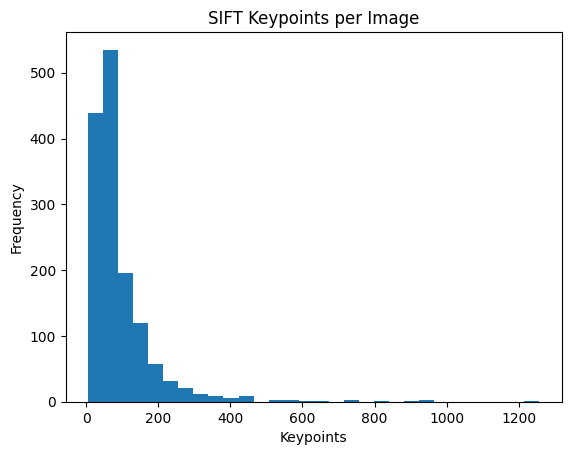

In [ ]:

def extract_sift(images):
    descriptors = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, desc = sift.detectAndCompute(gray, None)
        descriptors.append(desc)
    return descriptors

X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=RANDOM_STATE
)

sift_desc_train = extract_sift(X_train)
all_desc = np.vstack([d for d in sift_desc_train if d is not None])

plt.hist([len(d) for d in sift_desc_train if d is not None], bins=30)
plt.title("SIFT Keypoints per Image")
plt.xlabel("Keypoints")
plt.ylabel("Frequency")
plt.savefig(f"{OUT_FIG}/sift_keypoint_distribution.png", dpi=300)
plt.show()


### BoVW Training Clustering (with k-means)

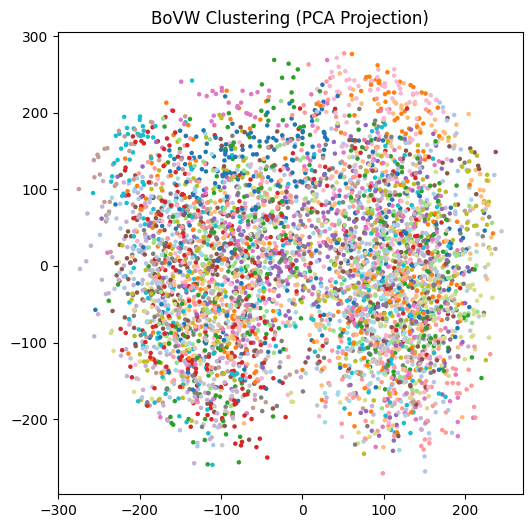

['outputs/model/bow_dictionary.pkl']

In [ ]:
kmeans = MiniBatchKMeans(
    n_clusters=NUM_CLUSTERS,
    random_state=RANDOM_STATE,
    batch_size=10000
)
kmeans.fit(all_desc)

# PCA visualization
pca = PCA(n_components=2, random_state=RANDOM_STATE)
desc_2d = pca.fit_transform(all_desc[:5000])
labels_2d = kmeans.predict(all_desc[:5000])

plt.figure(figsize=(6, 6))
plt.scatter(desc_2d[:, 0], desc_2d[:, 1],
            c=labels_2d, cmap="tab20", s=5)
plt.title("BoVW Clustering (PCA Projection)")
plt.savefig(f"{OUT_FIG}/bow_clustering_pca.png", dpi=300)
plt.show()

joblib.dump(kmeans, f"{OUT_MODEL}/bow_dictionary.pkl")


### Visualization Dictionary BoVW in action from SIFT

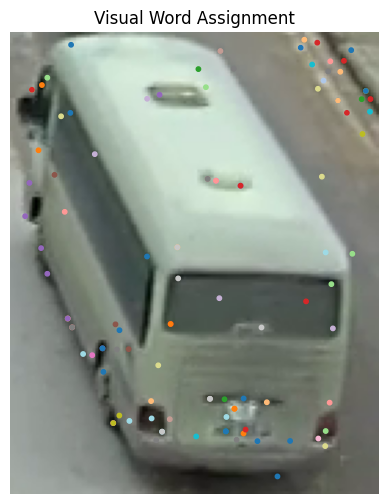

In [ ]:
desc = sift_desc_train[0]
assignments = kmeans.predict(desc)

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
plt.scatter(
    [kp.pt[0] for kp in kp],
    [kp.pt[1] for kp in kp],
    c=assignments[:len(kp)],
    cmap="tab20", s=10
)
plt.title("Visual Word Assignment")
plt.axis("off")
plt.savefig(f"{OUT_FIG}/visual_word_assignment.png", dpi=300)
plt.show()


### BoVW Histogram

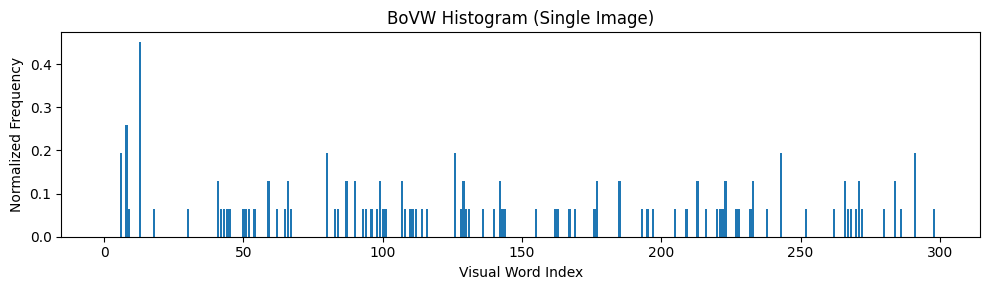

In [ ]:
def bow_hist(desc, kmeans):
    hist = np.zeros(NUM_CLUSTERS)
    if desc is not None:
        idx = kmeans.predict(desc)
        for i in idx:
            hist[i] += 1
    return hist / np.linalg.norm(hist)

hist = bow_hist(desc, kmeans)

plt.figure(figsize=(10, 3))
plt.bar(range(NUM_CLUSTERS), hist)

plt.title("BoVW Histogram (Single Image)")
plt.xlabel("Visual Word Index")
plt.ylabel("Normalized Frequency")

plt.tight_layout()
plt.savefig(f"{OUT_FIG}/bow_histogram.png", dpi=300)
plt.show()



### Histogram of Oriented Gradients

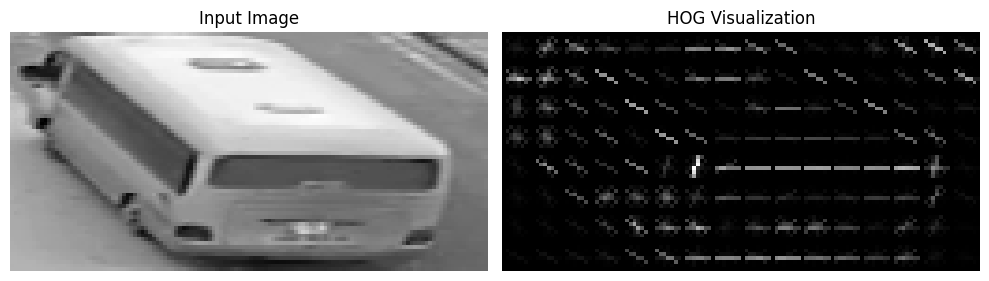

In [ ]:
gray = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
gray = cv2.resize(gray, (128, 64))
hog_feat, hog_img = hog(gray, **HOG_PARAMS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(gray, cmap="gray")
plt.title("Input Image"); plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(hog_img, cmap="gray")
plt.title("HOG Visualization"); plt.axis("off")

plt.tight_layout()
plt.savefig(f"{OUT_FIG}/hog_visualization.png", dpi=300)
plt.show()


### Feature Fusion (Histogram BoVW - HOG)

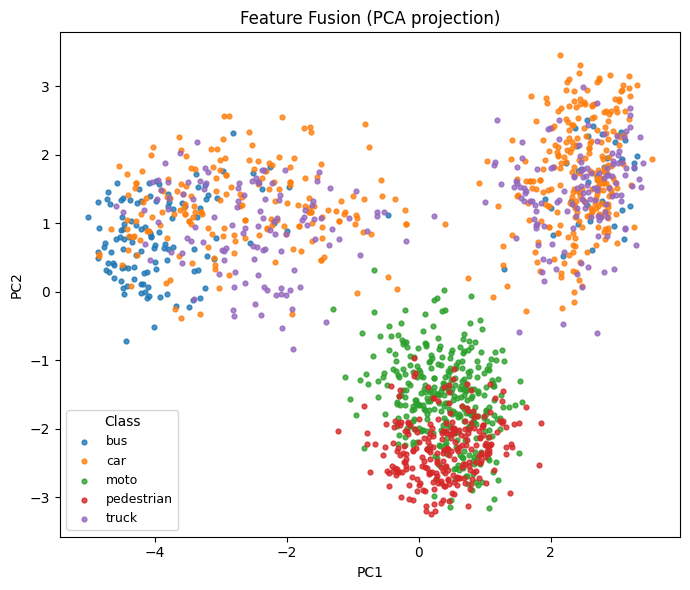

In [ ]:
def extract_hog(images):
    feats = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (128, 64))
        feat = hog(gray, **HOG_PARAMS)[0]
        feats.append(feat)
    return np.array(feats)

X_bow = np.array([bow_hist(d, kmeans) for d in sift_desc_train])
X_hog = extract_hog(X_train)

X_fused = np.hstack([X_bow, X_hog])

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_2d = pca.fit_transform(X_fused)

plt.figure(figsize=(7, 6))

classes = sorted(np.unique(y_train))
for cls in classes:
    idx = (y_train == cls)
    plt.scatter(
        X_2d[idx, 0],
        X_2d[idx, 1],
        s=12,
        alpha=0.8,
        label=id2label[cls]
    )

plt.title("Feature Fusion (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Class", loc="best", fontsize=9)
plt.tight_layout()
plt.savefig(f"{OUT_FIG}/feature_fusion_pca_labeled.png", dpi=300)
plt.show()



### Training Support Vector Machine

c:\Users\User\anaconda3\envs\thesis_nug\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

         bus       1.00      1.00      1.00       155
         car       1.00      1.00      1.00       443
        moto       1.00      1.00      1.00       340
  pedestrian       1.00      1.00      1.00       255
       truck       1.00      1.00      1.00       250

    accuracy                           1.00      1443
   macro avg       1.00      1.00      1.00      1443
weighted avg       1.00      1.00      1.00      1443



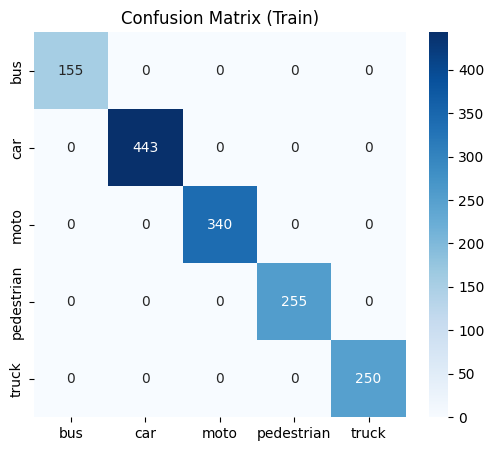

['outputs/model/sift_hog_svm.pkl']

In [16]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", LinearSVC(C=1.0, class_weight="balanced", max_iter=5000))
])

pipeline.fit(X_fused, y_train)

y_pred = pipeline.predict(X_fused)
print(classification_report(y_train, y_pred, target_names=id2label.values()))

cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=id2label.values(),
            yticklabels=id2label.values())
plt.title("Confusion Matrix (Train)")
plt.savefig(f"{OUT_FIG}/confusion_matrix.png", dpi=300)
plt.show()

joblib.dump(pipeline, f"{OUT_MODEL}/sift_hog_svm.pkl")


### Test Model Performance (Accuracy, Precision, Recall, F1-Score)

Test samples count: 50
              precision    recall  f1-score   support

         bus       1.00      1.00      1.00        10
         car       1.00      1.00      1.00        10
        moto       1.00      0.90      0.95        10
  pedestrian       0.91      1.00      0.95        10
       truck       1.00      1.00      1.00        10

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



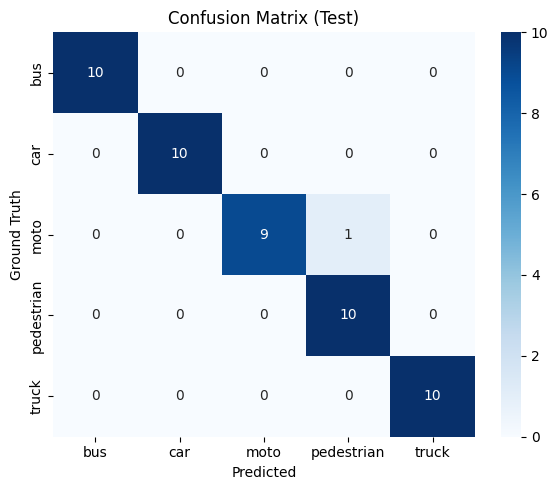

In [25]:

X_test_imgs, y_test, _ = load_dataset(TEST_DIR)
sift_desc_test = extract_sift(X_test_imgs)
X_test_bow = np.array([bow_hist(d, kmeans) for d in sift_desc_test])
X_test_hog = extract_hog(X_test_imgs)
X_test_fused = np.hstack([X_test_bow, X_test_hog])
print("Test samples count:", X_test_fused.shape[0])

y_test_pred = pipeline.predict(X_test_fused)

print(classification_report(
    y_test,
    y_test_pred,
    target_names=id2label.values()
))

cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))

sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=id2label.values(),
            yticklabels=id2label.values())
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")

plt.tight_layout()
plt.savefig(f"{OUT_FIG}/confusion_matrix_test.png", dpi=300)
plt.show()
